In [1]:
# modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

### Import Data

In [2]:
netflix_df = pd.read_csv('./i_sub.csv')
disney_df = pd.read_csv('./a_sub.csv')

In [3]:
netflix_df.head()

,Unnamed: 0,selftext,subreddit,title,post_type
0,0,It causes nothing but frustration. With it bei...,netflix,Please for the love of god remove the My List ...,submission
1,1,[removed],netflix,Netflix is having 1.5 billions IN REVENUE ALON...,submission
2,2,NaN,netflix,Netflix rolls out a shocking update on its sub...,submission
3,3,[removed],netflix,After about 20 years.....I CANCELLED NETFLIX!!!!,submission
4,4,I can name 3 great series from Netflix in my o...,netflix,What Netflix series are worth watching?,submission


In [4]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1337 non-null   int64 
 1   selftext    824 non-null    object
 2   subreddit   1337 non-null   object
 3   title       1337 non-null   object
 4   post_type   1337 non-null   object
dtypes: int64(1), object(4)
memory usage: 52.4+ KB


In [5]:
disney_df.head()

,Unnamed: 0,selftext,subreddit,title,post_type
0,0,[removed],DisneyPlus,Disney plus atmos,submission
1,1,[removed],DisneyPlus,"I want to watch the Netflix/Marvel shows, but ...",submission
2,2,NaN,DisneyPlus,Disney Vintage Lot!!(Mickey Mouse &amp; The In...,submission
3,3,NaN,DisneyPlus,The VOD of Harmonious Live is now available on...,submission
4,4,NaN,DisneyPlus,"It Was Always Me (""Siempre fui yo""), a Colombi...",submission


In [6]:
disney_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1329 non-null   int64 
 1   selftext    871 non-null    object
 2   subreddit   1329 non-null   object
 3   title       1329 non-null   object
 4   post_type   1329 non-null   object
dtypes: int64(1), object(4)
memory usage: 52.0+ KB


In [7]:
#We can observe that the selftext has quite a few values that are missing and some contains [removed]
#so we will try to handle the missing values in the next section

In [8]:
# Drop 'Unnamed: 0' column
netflix_df.drop(columns=['Unnamed: 0'], inplace=True)
disney_df.drop(columns=['Unnamed: 0'], inplace=True)

### Data Cleaning

In [9]:
def clean_df(df):
    df["selftext"].fillna("", inplace = True)
    df["selftext"].replace("[removed]"," ", inplace = True)
    df["selftext"].replace("[deleted]", " ", inplace = True)
    df["text"] = df["title"] +" "+ df["selftext"]
    
    df.drop(columns = ["selftext", "title"], axis = 1, inplace = True)
    df.drop_duplicates(subset=['text'], keep = 'first', inplace = True)
    
    print(df.shape)
    print(df.isnull().sum())
    
    return df

In [10]:
netflix_df = clean_df(netflix_df)
disney_df = clean_df(disney_df)

(1337, 3)
subreddit    0
post_type    0
text         0
dtype: int64
(1329, 3)
subreddit    0
post_type    0
text         0
dtype: int64


In [11]:
netflix_df.describe()

,subreddit,post_type,text
count,1337,1337,1337
unique,1,1,1337
top,netflix,submission,Please for the love of god remove the My List ...
freq,1337,1337,1


In [12]:
disney_df.describe()

,subreddit,post_type,text
count,1329,1329,1329
unique,1,1,1329
top,DisneyPlus,submission,Disney plus atmos
freq,1329,1329,1


In [13]:
#We have checked from the above that both netflix_df and disney_df has 1 unique post_type which is 'submission'
#We will not require this column for NlP, hence we will drop the column
netflix_df.drop(columns = 'post_type', inplace = True)
disney_df.drop(columns = 'post_type', inplace = True)

In [14]:
#Combining the 2 subreddits:
df = pd.concat([netflix_df, disney_df])

#Check the shape of the combined dataframe:
df.shape

(2666, 2)

In [15]:
#interesting post:
df.iloc[1]['text']

'Netflix is having 1.5 billions IN REVENUE ALONE each year. How is that they are "Struggling to make new shows within budget"?  '

- Label Target Variable

In [16]:
#Rename the subreddit as the target columns
df.rename(columns = {'subreddit': 'target'}, inplace=True)

#Convert netflix/ disney into binary labels (1 for netflix, 0 for disney)
df['target'] = df['target'].map({'netflix':1, 'DisneyPlus': 0})

In [17]:
df.head()

,target,text
0,1,Please for the love of god remove the My List ...
1,1,Netflix is having 1.5 billions IN REVENUE ALON...
2,1,Netflix rolls out a shocking update on its sub...
3,1,After about 20 years.....I CANCELLED NETFLIX!!...
4,1,What Netflix series are worth watching? I can ...


In [18]:
print(f"No. of Missing values : {df.isnull().sum().sum()}")
print(f"No. of duplicates: {df.duplicated().sum()}")

No. of Missing values : 0
No. of duplicates: 0


- Cleaning text

-- Remove unicode characters <br>
Reference : [Unicode Characters](https://thecleverprogrammer.com/2021/03/29/remove-unicode-characters-using-python/)

In [19]:
def clean_text(sentence):
    
    # 1. Remove url links
    submission = re.sub(r"http\S+", "", sentence)

    # 2. Remove HTML.
    comment_text = BeautifulSoup(submission).get_text()
    
    # 3. Remove non-letters (e.g.punctuations, emojis etc.).
    letters_only = re.sub("[^a-zA-Z]", " ", comment_text)
    
    # 4. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 5. Convert the stop words to a set (because searching a set is much faster than searching a list).
    # Add in additional stopwords
    stops = set(stopwords.words('english') + 
                ['netflix','disney', 'plus', 'disneyplus', 'www', 'reddit', 'word'])
    #stops = set(stopwords.words('english') + ['netflix', 'disney plus', 'disney', 'plus',
                                              #'disneyplus', 'https','com', 'www', 'reddit', 'poll'])
    
    # 6. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [20]:
#Apply clean text function
netflix_df['text'] = netflix_df['text'].apply(clean_text)
disney_df['text'] = disney_df['text'].apply(clean_text)
df['text'] = df['text'].apply(clean_text)

C:\Users\kezia\anaconda3\envs\dsi30\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [21]:
df.shape, netflix_df.shape, disney_df.shape

((2666, 2), (1337, 2), (1329, 2))

- Lemmatizing

In [22]:
# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

In [23]:
# Define function to lemmatize the words
def lemmatize_words(text):
    word = text.split()
    lemma_words = ''
    for i in word:
        lemma_words += lemmatizer.lemmatize(i) + ' '
    return lemma_words

In [24]:
#Apply lemmatize_words function to the text column
netflix_df['text'] = netflix_df['text'].apply(lemmatize_words)
disney_df['text'] = disney_df['text'].apply(lemmatize_words)
df['text'] = df['text'].apply(lemmatize_words)

In [25]:
df.shape, netflix_df.shape, disney_df.shape

((2666, 2), (1337, 2), (1329, 2))

- Count Vectorizer

In [26]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = ['english'],
                             max_features = 100,
                            ngram_range=(1,4)) 

In [27]:
vector_netflix = vectorizer.fit_transform(netflix_df['text'])
vector_netflix= pd.DataFrame(vector_netflix.todense(), columns=vectorizer.get_feature_names_out())

vector_disney = vectorizer.fit_transform(disney_df['text'])
vector_disney= pd.DataFrame(vector_disney.todense(), columns=vectorizer.get_feature_names_out())
#vector_disney = vectorizer.fit_transform(disney_df)

In [28]:
vector_netflix

,account,also,anyone,anything,app,available,back,bad,best,better,...,video,want,watch,watched,watching,way,well,work,would,year
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
1333,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
1334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [29]:
vector_disney

,account,added,also,anyone,anyone know,anything,app,available,back,change,...,want,war,watch,watching,way,window,work,working,would,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1325,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Exploratory Data Analysis

#### Top Common Words

In [30]:
netflix_top_words = pd.DataFrame(vector_netflix.sum().sort_values(ascending=False).head(30), 
                                 columns=['Count'])
netflix_top_words

,Count
show,447
thing,263
like,238
movie,229
watch,224
season,196
stranger,194
stranger thing,190
episode,176
one,169


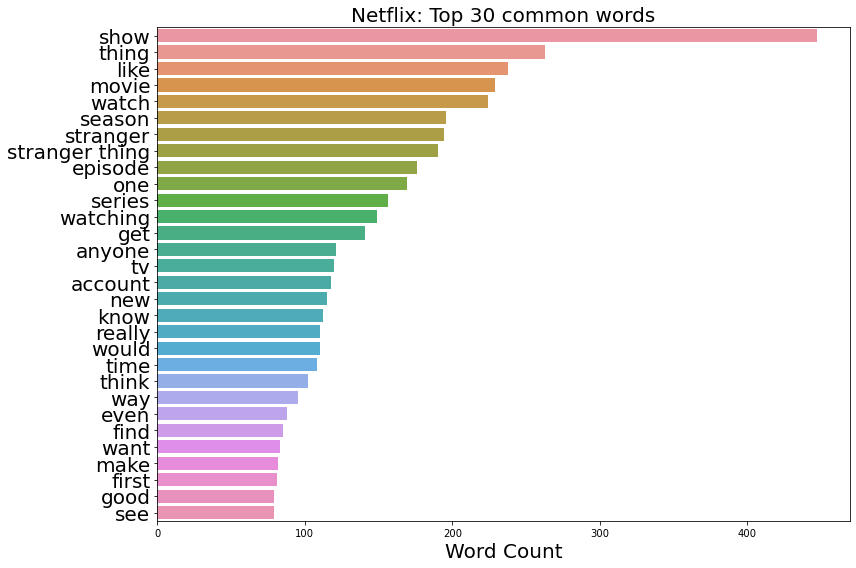

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='Count', y=netflix_top_words.index , data=netflix_top_words)
plt.title('Netflix: Top 30 common words',fontsize=20)
plt.xlabel('Word Count', fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

In [32]:
disney_top_words = pd.DataFrame(vector_disney.sum().sort_values(ascending=False).head(30), 
                                 columns=['Count'])
disney_top_words

,Count
show,247
episode,198
movie,197
app,181
watch,180
like,151
know,142
tv,140
anyone,125
season,121


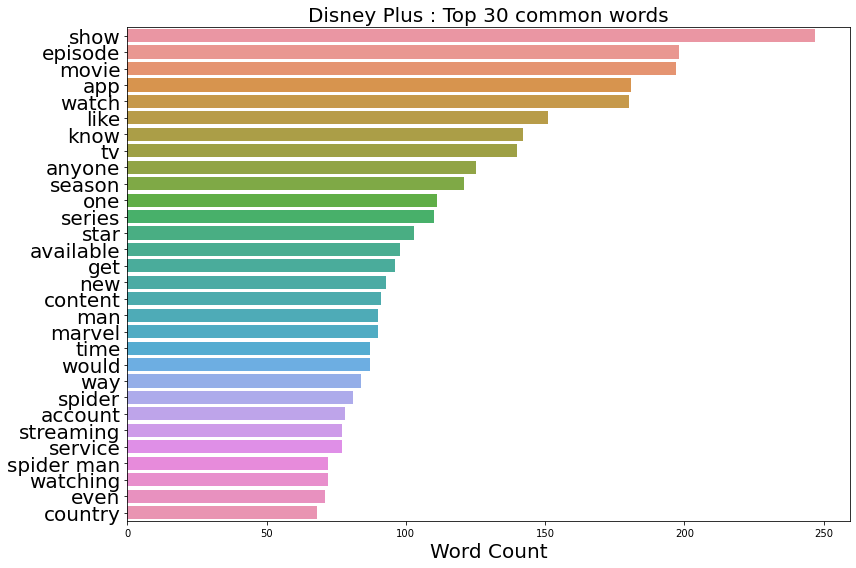

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='Count', y=disney_top_words.index , data=disney_top_words)
plt.title('Disney Plus : Top 30 common words',fontsize=20)
plt.xlabel('Word Count', fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

In [34]:
# words that appear in both subreddits.
both_subreddits = []
for i in range(15):
    for j in range(15):
        if netflix_top_words.index[i] == disney_top_words.index[j]:
            both_subreddits.append(netflix_top_words.index[i])
both_subreddits

['show',
 'like',
 'movie',
 'watch',
 'season',
 'episode',
 'one',
 'series',
 'get',
 'anyone',
 'tv']

In [35]:
netflix_words = list(netflix_top_words.index)
disney_words = list(disney_top_words.index)
print('====== Both =======')
print(both_subreddits)
print('=====Netflix=====')
print([x for x in netflix_words if x not in set(disney_words)])
print('=====Disney +=====')
print([x for x in disney_words if x not in set(netflix_words)])

====== Both =======
['show', 'like', 'movie', 'watch', 'season', 'episode', 'one', 'series', 'get', 'anyone', 'tv']
=====Netflix=====
['thing', 'stranger', 'stranger thing', 'really', 'think', 'find', 'want', 'make', 'first', 'good', 'see']
=====Disney +=====
['app', 'star', 'available', 'content', 'man', 'marvel', 'spider', 'streaming', 'service', 'spider man', 'country']


- Stranger Thing is currently the most trending series that are only available on Netflix
- We can also see that Disney + provide movies that are not available elsewhere such as Marvel

In [36]:
#We will remove the top common words for better classification:
df.replace(both_subreddits, "", inplace=True)

- Wordcloud

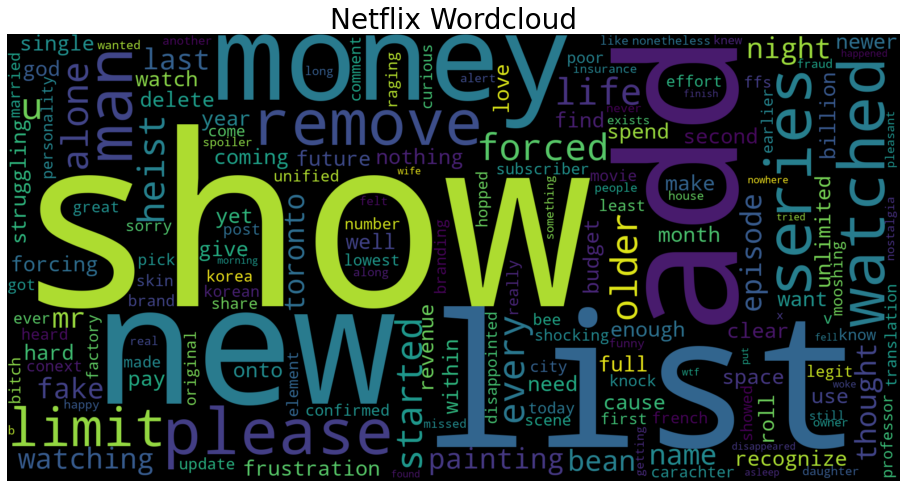

In [37]:
wordcloud = WordCloud(stopwords=set(stopwords.words('english') + ['netflix']),
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df[df['target']==1].values))

plt.figure(figsize=(16,9))
plt.title('Netflix Wordcloud', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

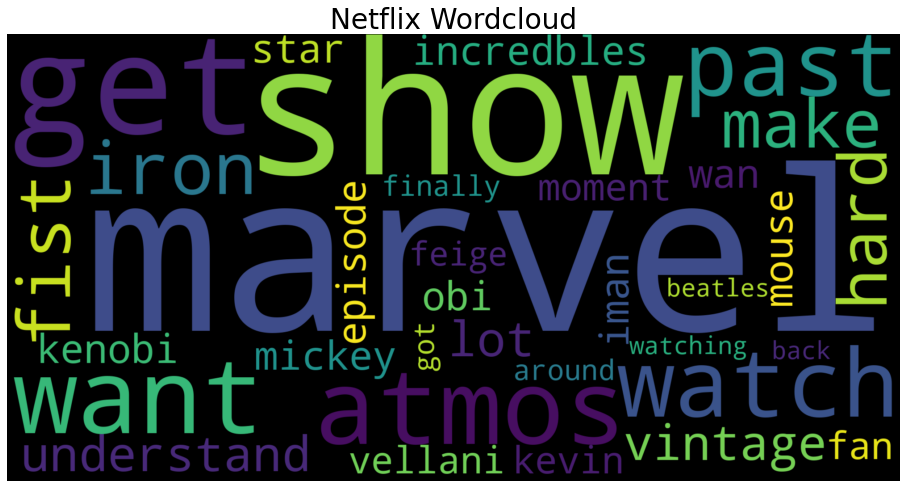

In [38]:
wordcloud = WordCloud(stopwords=set(stopwords.words('english') + ['disney']),
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(df[df['target']==0].values))

plt.figure(figsize=(16,9))
plt.title('Netflix Wordcloud', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

### Model Preprocessing

In [39]:
# Assigning X and y
X = df['text']
y = df['target']

In [40]:
X.shape, y.shape

((2666,), (2666,))

In [41]:
# Train test splitting df
# Shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42)

In [42]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1999,) (1999,)
(667,) (667,)


In [43]:
# What stratify = y do:

print(y_train.value_counts(normalize=True))

print(y_test.value_counts(normalize=True))

1    0.501251
0    0.498749
Name: target, dtype: float64
1    0.502249
0    0.497751
Name: target, dtype: float64


### Baseline Accuracy

In [44]:
#Baseline accuracy, to tell whether our model is better than null model
y.value_counts(normalize=True)

1    0.5015
0    0.4985
Name: target, dtype: float64

### Modeling

- Creating functions for evaluation metrics

In [45]:
def score_evaluation(model):
    print("======== All Scores ========")
    print(f"Best Score: {model.best_score_}")
    print(f"Train Score: {model.score(X_train, y_train)}")
    print(f"Test Score: {model.score(X_test, y_test)}\n")
    print("======== Best Params =======")
    for param, value in model.best_params_.items():
        print(f"{param}: {value}")

In [46]:
def performance_evaluation(model, X_test, y_test):
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d');
    
    print('===== Performance =====')
    # accuracy = (tn + tp) / (tn + fp + fn + tp) 
    accuracy = accuracy_score(y_test, preds) 
    print(f'Accuracy: {round(accuracy, 4)}')
    
    specificity = tn / (tn + fp)
    print(f'Specificity: {round(specificity, 4)}')
    
    # sensitivity = tp / (tp + fn)
    sensitivity = recall_score(y_test, preds)
    print(f'Sensitivity: {round(sensitivity, 4)}')
    
    # precision = tp / (tp + fp)
    precision = precision_score(y_test, preds)
    print(f'Precision: {round(precision, 4)}')
    
    # f1score = 2 * (precision*sensitivity) / (precision + sensitivity)
    f1score = f1_score(y_test, preds)
    print(f'F1 score: {round(f1score, 4)}')
    
    roc_auc = roc_auc_score(y_test, preds)
    print(f'ROC AUC score: {round(roc_auc, 4)}')

- Tuning hyperparameters for different models

### 1. Logistic Regression

#### 1.1 Count Vectorizer

In [47]:
#Grid Search
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'cvec__max_features': [20000], #[5000, 10000, 20000]
    'cvec__ngram_range': [(1, 2)], #[(1, 1), (1, 2)]
    'lr__penalty': ['l2'], #['l1', 'l2']
    'lr__C': np.logspace(-10, 0, 10)
}
gs_cvec_lr = GridSearchCV(cvec_lr, param_grid=pipe_params, cv=5, verbose=1)
gs_cvec_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_features': [20000],
                         'cvec__ngram_range': [(1, 2)],
                         'lr__C': array([1.00000000e-10, 1.29154967e-09, 1.66810054e-08, 2.15443469e-07,
       2.78255940e-06, 3.59381366e-05, 4.64158883e-04, 5.99484250e-03,
       7.74263683e-02, 1.00000000e+00]),
                         'lr__penalty': ['l2']},
             verbose=1)

In [48]:
score_evaluation(gs_cvec_lr)

======== All Scores ========
Best Score: 0.7468671679197996
Train Score: 0.9879939969984992
Test Score: 0.7691154422788605

======== Best Params =======
cvec__max_features: 20000
cvec__ngram_range: (1, 2)
lr__C: 1.0
lr__penalty: l2


===== Performance =====
Accuracy: 0.7691
Specificity: 0.8012
Sensitivity: 0.7373
Precision: 0.7891
F1 score: 0.7623
ROC AUC score: 0.7693


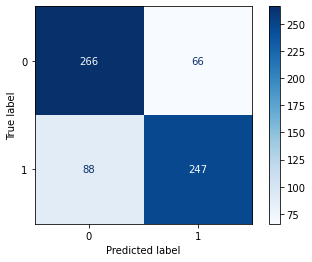

In [49]:
performance_evaluation(gs_cvec_lr, X_test, y_test)

In [50]:
#Find features importance:
print("Top words for Netflix")
coef1 = gs_cvec_lr.best_estimator_[0].get_feature_names_out()
coef_val = gs_cvec_lr.best_estimator_.named_steps.lr.coef_
coef_val = np.exp(coef_val).T
df_coef = pd.DataFrame(coef_val, index=coef1)
df_coef.columns = ["coef"]
display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))
print("Top words for Disney Plus")
display(df_coef.sort_values(by = ['coef'], ascending = True).head(20))

Top words for Netflix


,coef
stranger,4.046179
stranger thing,4.045921
anime,3.427516
lucifer,2.925092
top,2.750433
resident evil,2.580114
resident,2.580114
evil,2.561112
thing,2.513770
think,2.474837


Top words for Disney Plus


,coef
marvel,0.104338
mena,0.170031
lightyear,0.253765
kenobi,0.321558
login,0.338565
missing,0.345084
spider,0.351543
house,0.359553
spider man,0.379342
country,0.385042


The highest coefficient of 4.05 corresponds to the word 'stranger thing.' This means that a unit increase of the word "stranger thing" suggests that it is 4.05 more likely to belong to Netflix subreddit, holding all else constant. While on the other hand the lowest coefficient belongs to the word "marvel", indicating that it belongs to Disney Plus subreddit. 

#### 1.2 TF-IDF Vectorizer 

In [51]:
tf_lr = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tf__max_features': [4000],               #[2000, 3000, 4000]
    'tf__min_df': [2],                        #[2, 3, 4]
    'tf__max_df': [.3],                       #[.3, .4, .5]
    'tf__ngram_range': [(1,2)],               #[(1,1), (1,2)]
    'lr__C': list(np.linspace(2.5, 3.5, 5))
}

gs_tf_lr = GridSearchCV(tf_lr, 
                  param_grid=pipe_params, 
                  cv=5, verbose = 1, n_jobs = -1) 

gs_tf_lr.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'lr__C': [2.5, 2.75, 3.0, 3.25, 3.5],
                         'tf__max_df': [0.3], 'tf__max_features': [4000],
                         'tf__min_df': [2], 'tf__ngram_range': [(1, 2)]},
             verbose=1)

In [52]:
score_evaluation(gs_tf_lr)

======== All Scores ========
Best Score: 0.7633671679197995
Train Score: 0.9574787393696849
Test Score: 0.760119940029985

======== Best Params =======
lr__C: 3.0
tf__max_df: 0.3
tf__max_features: 4000
tf__min_df: 2
tf__ngram_range: (1, 2)


===== Performance =====
Accuracy: 0.7601
Specificity: 0.7711
Sensitivity: 0.7493
Precision: 0.7676
F1 score: 0.7583
ROC AUC score: 0.7602


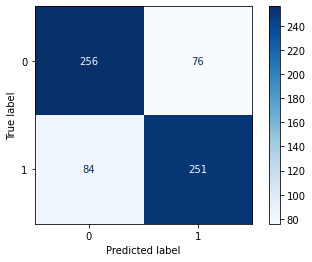

In [53]:
performance_evaluation(gs_tf_lr, X_test, y_test)

In [54]:
#Find features importance:
print("Top words for Netflix")
coef1 = gs_tf_lr.best_estimator_[0].get_feature_names_out()
coef_val = gs_tf_lr.best_estimator_.named_steps.lr.coef_
coef_val = np.exp(coef_val).T
df_coef = pd.DataFrame(coef_val, index=coef1)
df_coef.columns = ["coef"]
display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))
print("Top words for Disney Plus")
display(df_coef.sort_values(by = ['coef'], ascending = True).head(20))

Top words for Netflix


,coef
stranger,45.390869
stranger thing,44.199252
thing,21.448270
anime,11.908944
think,10.587466
lucifer,9.748127
resident evil,9.176790
resident,9.176790
evil,8.549357
top,7.548647


Top words for Disney Plus


,coef
marvel,0.007414
mena,0.041375
lightyear,0.073584
spider,0.075263
service,0.079106
kenobi,0.083354
country,0.088907
spider man,0.091313
missing,0.100125
star,0.101052


### 2. Multinomial Naïve Bayes

#### 2.1 Count Vectorizer

In [55]:
cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB() )
])

pipe_params = {
    'cvec__stop_words': [None],        #[None, 'english']
    'cvec__max_features': [20000],     #[5000, 10000, 20000]
    'cvec__ngram_range': [(1, 2)],     #[(1, 1), (1, 2)]
    'nb__alpha': [0.4, 0.5, 0.6]                 #[0, 0.4, 0.25, 0.5, 0.75, 1]
    # min_df
    # max_df
}
gs_cvec_nb = GridSearchCV(cvec_nb, param_grid=pipe_params, cv=5, verbose=1, n_jobs=-1)
gs_cvec_nb.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [20000],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None],
                         'nb__alpha': [0.4, 0.5, 0.6]},
             verbose=1)

In [56]:
score_evaluation(gs_cvec_nb)

======== All Scores ========
Best Score: 0.785874686716792
Train Score: 0.9644822411205602
Test Score: 0.775112443778111

======== Best Params =======
cvec__max_features: 20000
cvec__ngram_range: (1, 2)
cvec__stop_words: None
nb__alpha: 0.4


===== Performance =====
Accuracy: 0.7751
Specificity: 0.756
Sensitivity: 0.794
Precision: 0.7666
F1 score: 0.7801
ROC AUC score: 0.775


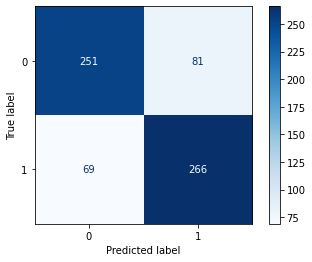

In [57]:
performance_evaluation(gs_cvec_nb, X_test, y_test)

In [58]:
#Find fetures importance:
coef1 = gs_cvec_nb.best_estimator_[0].get_feature_names_out()
log_prob_diff = gs_cvec_nb.best_estimator_.steps[1][1].feature_log_prob_[1] - gs_cvec_nb.best_estimator_.steps[1][1].feature_log_prob_[0]
df_coef = pd.DataFrame(log_prob_diff, index=coef1)
df_coef.columns = ["coef"]
display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))

,coef
resident,4.577415
resident evil,4.577415
stranger,4.497050
stranger thing,4.468760
thing season,4.198618
lucifer,3.978758
anime,3.847566
saul,3.696526
vecna,3.696526
better call,3.696526


#### 2.2 TF-IDF Vectorizer

In [59]:
tf_nb = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tf__max_features': [4000], #[2000, 3000, 4000]
    'tf__min_df': [2],          #[2, 3]
    'tf__max_df': [.3],         #[.3, .4, .5]
    'tf__ngram_range': [(1,2)], #[(1,1), (1,2)]
    'nb__alpha': [0.0325],      #list(np.linspace(0.01,0.1,5)  
}    #high alpha -> underfitting (adding large counts to everything, diluting the signal in the data)
    #low alpha -> overfitting
    
gs_tf_nb = GridSearchCV(tf_nb,
                  param_grid=pipe_params, 
                  cv=5, verbose = 1, n_jobs = -1) 

gs_tf_nb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.0325], 'tf__max_df': [0.3],
                         'tf__max_features': [4000], 'tf__min_df': [2],
                         'tf__ngram_range': [(1, 2)]},
             verbose=1)

In [60]:
score_evaluation(gs_tf_nb)

======== All Scores ========
Best Score: 0.7753809523809524
Train Score: 0.9424712356178089
Test Score: 0.7706146926536732

======== Best Params =======
nb__alpha: 0.0325
tf__max_df: 0.3
tf__max_features: 4000
tf__min_df: 2
tf__ngram_range: (1, 2)


===== Performance =====
Accuracy: 0.7706
Specificity: 0.747
Sensitivity: 0.794
Precision: 0.76
F1 score: 0.7766
ROC AUC score: 0.7705


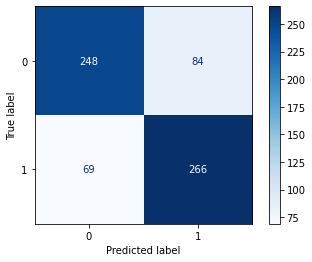

In [61]:
performance_evaluation(gs_tf_nb, X_test, y_test)

In [62]:
#Find fetures importance:
coef1 = gs_tf_nb.best_estimator_[0].get_feature_names_out()
log_prob_diff = gs_tf_nb.best_estimator_.steps[1][1].feature_log_prob_[1] - gs_tf_nb.best_estimator_.steps[1][1].feature_log_prob_[0]
df_coef = pd.DataFrame(log_prob_diff, index=coef1)
df_coef.columns = ["coef"]
display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))

,coef
resident,5.776820
resident evil,5.776820
thing season,5.602164
stranger,5.176693
stranger thing,5.167534
anime,5.127268
saul,5.044541
better call,5.044541
call saul,5.044541
lucifer,5.044479


### 3. Random Forest

#### 3.1 Count Vectorizer

In [63]:
cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'cvec__stop_words': ['english'], 
    'cvec__max_features': [20000],       #[10000, 20000, 30000]
    'cvec__max_df' : [0.9],             #[0.80, 0.85, 0.90, 0.95]
    'cvec__min_df' : [3],                #[2, 3, 4, 5]
    'cvec__ngram_range': [(1, 2)],       #[(1, 1), (1, 2), (1,3)]
    'rf__n_estimators': [3000],          #[2000, 3000, 4000]
    'rf__max_depth': [20]                #[10, 20, 30]
}

gs_cvec_rf = GridSearchCV(cvec_rf, param_grid=pipe_params, cv=5, verbose=3, n_jobs=-1)
gs_cvec_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [20000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': ['english'], 'rf__max_depth': [20],
                         'rf__n_estimators': [3000]},
             verbose=3)

In [64]:
#Find feature importances
cvec_rf = gs_cvec_rf.best_estimator_

rf_feat = cvec_rf[:-1].get_feature_names_out()
rf_feat_imp = cvec_rf[1:2].steps[0][1].feature_importances_

df_rf_feat = pd.DataFrame(data=rf_feat_imp, index=rf_feat)
df_rf_feat.columns = ['coef']

df_rf_feat.sort_values(by='coef', ascending=False).head(30)

,coef
stranger,0.054725
stranger thing,0.050394
thing,0.039794
marvel,0.031480
star,0.017451
resident evil,0.015694
resident,0.015440
mena,0.014745
evil,0.013834
obi,0.012937


In [65]:
score_evaluation(gs_cvec_rf)

======== All Scores ========
Best Score: 0.721844611528822
Train Score: 0.864432216108054
Test Score: 0.7136431784107946

======== Best Params =======
cvec__max_df: 0.9
cvec__max_features: 20000
cvec__min_df: 3
cvec__ngram_range: (1, 2)
cvec__stop_words: english
rf__max_depth: 20
rf__n_estimators: 3000


===== Performance =====
Accuracy: 0.7136
Specificity: 0.7771
Sensitivity: 0.6507
Precision: 0.7466
F1 score: 0.6954
ROC AUC score: 0.7139


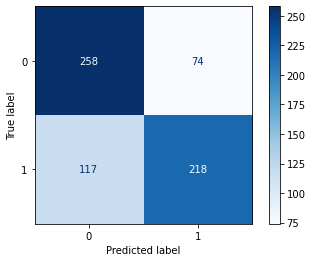

In [66]:
performance_evaluation(gs_cvec_rf, X_test, y_test)

#### 3.2 TF-IDF Vectorizer

In [67]:
tf_rf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'tf__stop_words': ['english'], 
    'tf__max_features': [10000],       #[10000, 20000]
    'tf__max_df' : [0.9],             #[0.70, 0.90, 0.95]
    'tf__min_df' : [3],                #[2, 3, 4, 5]
    'tf__ngram_range': [(1, 2)],       #[(1, 1), (1, 2), (1,3)]
    'rf__n_estimators': [3000],          #[2000, 3000, 4000]
    'rf__max_depth': [20]                #[10, 20]
}

gs_tf_rf = GridSearchCV(tf_rf, param_grid=pipe_params, cv=5, verbose=3, n_jobs=-1)
gs_tf_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [20], 'rf__n_estimators': [3000],
                         'tf__max_df': [0.9], 'tf__max_features': [10000],
                         'tf__min_df': [3], 'tf__ngram_range': [(1, 2)],
                         'tf__stop_words': ['english']},
             verbose=3)

In [68]:
score_evaluation(gs_tf_rf)

======== All Scores ========
Best Score: 0.7318458646616541
Train Score: 0.8894447223611806
Test Score: 0.7346326836581709

======== Best Params =======
rf__max_depth: 20
rf__n_estimators: 3000
tf__max_df: 0.9
tf__max_features: 10000
tf__min_df: 3
tf__ngram_range: (1, 2)
tf__stop_words: english


===== Performance =====
Accuracy: 0.7346
Specificity: 0.747
Sensitivity: 0.7224
Precision: 0.7423
F1 score: 0.7322
ROC AUC score: 0.7347


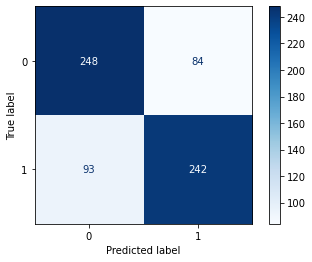

In [69]:
performance_evaluation(gs_tf_rf, X_test, y_test)

In [70]:
#Find feature importances
tf_rf = gs_tf_rf.best_estimator_

rf_feat = tf_rf[:-1].get_feature_names_out()
rf_feat_imp = tf_rf[1:2].steps[0][1].feature_importances_

df_rf_feat = pd.DataFrame(data=rf_feat_imp, index=rf_feat)
df_rf_feat.columns = ['coef']

df_rf_feat.sort_values(by='coef', ascending=False).head(30)

,coef
stranger,0.051544
stranger thing,0.048280
thing,0.042454
marvel,0.030044
star,0.017877
resident,0.015378
resident evil,0.015132
evil,0.014134
mena,0.014047
app,0.012101


### R2 Scores and ROC AUC Plot

In [71]:
summary = []

#Logistic Regression
summary.append(['Logistic Regression', 'Count Vectorizer',
                gs_cvec_lr.best_score_,gs_cvec_lr.score(X_train,y_train),gs_cvec_lr.score(X_test,y_test)])
summary.append(['Logistic Regression', 'TF-IDF Vectorizer',
                gs_tf_lr.best_score_,gs_tf_lr.score(X_train,y_train),gs_tf_lr.score(X_test,y_test)])

#Multinomial NB
summary.append(['Multinomial NB', 'Count Vectorizer',
                gs_cvec_nb.best_score_,gs_cvec_nb.score(X_train,y_train),gs_cvec_nb.score(X_test,y_test)])
summary.append(['Multinomial NB', 'TFI-DF Vectorizer',
                gs_tf_nb.best_score_,gs_tf_nb.score(X_train,y_train),gs_tf_nb.score(X_test,y_test)])

#Random Forest
summary.append(['Random Forest', 'Count Vectorizer',
                gs_cvec_rf.best_score_,gs_cvec_rf.score(X_train,y_train),gs_cvec_rf.score(X_test,y_test)])
summary.append(['Random Forest', 'TFI-DF Vectorizer',
                gs_tf_rf.best_score_,gs_tf_rf.score(X_train,y_train),gs_tf_rf.score(X_test,y_test)])

summary_table = pd.DataFrame(summary, columns = ['model', 
                                 'vectorizer', 
                                 'best_score',
                                 'train_score',
                                 'test_score(Accuracy)'])
summary_table

,model,vectorizer,best_score,train_score,test_score(Accuracy)
0,Logistic Regression,Count Vectorizer,0.746867,0.987994,0.769115
1,Logistic Regression,TF-IDF Vectorizer,0.763367,0.957479,0.760120
2,Multinomial NB,Count Vectorizer,0.785875,0.964482,0.775112
3,Multinomial NB,TFI-DF Vectorizer,0.775381,0.942471,0.770615
4,Random Forest,Count Vectorizer,0.721845,0.864432,0.713643
5,Random Forest,TFI-DF Vectorizer,0.731846,0.889445,0.734633


We score the model by accuracy because it is not very significant if we incorrectly predict a post as Netflix compared to incorrectly predicting a post as Disney Plus. Thus, false positives and false negatives are assumed to have equal weightage. Therefore, we will use accuracy as the metric for evaluation.

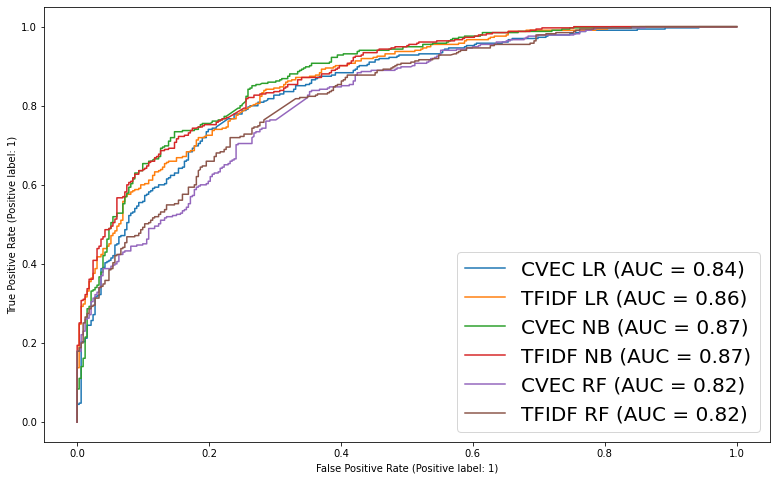

In [72]:
fig, ax = plt.subplots(figsize=(13, 8))

#logistic Regression
cvec_lr_disp = RocCurveDisplay.from_estimator(gs_cvec_lr, X_test, y_test, name = 'CVEC LR', ax = ax)
tf_lr_disp = RocCurveDisplay.from_estimator(gs_tf_lr, X_test, y_test, name = 'TFIDF LR', ax = cvec_lr_disp.ax_)

#Multinomial NB
cvec_nb_disp = RocCurveDisplay.from_estimator(gs_cvec_nb, X_test, y_test, name = 'CVEC NB', ax = cvec_lr_disp.ax_)
tf_nb_disp = RocCurveDisplay.from_estimator(gs_tf_nb, X_test, y_test, name = 'TFIDF NB', ax = cvec_lr_disp.ax_)

#Random Forest
cvec_rf_disp = RocCurveDisplay.from_estimator(gs_cvec_rf, X_test, y_test, name = 'CVEC RF', ax = cvec_lr_disp.ax_)
tf_rf_disp = RocCurveDisplay.from_estimator(gs_tf_rf, X_test, y_test, name = 'TFIDF RF', ax = cvec_lr_disp.ax_)

plt.legend(prop={"size":20});

CVEC NB has the highest ROC score. However, this might not be the best method to evaluate the model's
performance.

### Final Model - Random Forest and Count Vectorizer

In [73]:
#we will use the hyperparameters based on the grid search:
score_evaluation(gs_tf_rf)

======== All Scores ========
Best Score: 0.7318458646616541
Train Score: 0.8894447223611806
Test Score: 0.7346326836581709

======== Best Params =======
rf__max_depth: 20
rf__n_estimators: 3000
tf__max_df: 0.9
tf__max_features: 10000
tf__min_df: 3
tf__ngram_range: (1, 2)
tf__stop_words: english


In [74]:
cvec = CountVectorizer(analyzer = "word",                        
                         tokenizer = None, 
                         preprocessor = None,
                         stop_words = "english", 
                         max_features = 20000,
                         max_df = 0.9,
                         min_df = 3,
                         ngram_range = (1,2))

rf = RandomForestClassifier(n_estimators=3000,
                            max_depth=20)

pipe = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=20000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english')),
                ('rf',
                 RandomForestClassifier(max_depth=20, n_estimators=3000))])

In [75]:
pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=20000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english')),
                ('rf',
                 RandomForestClassifier(max_depth=20, n_estimators=3000))])

- Features importance

In [76]:
rf_feat = cvec.get_feature_names_out()
rf_feat_imp = rf.feature_importances_

df_rf_feat = pd.DataFrame(data=rf_feat_imp, index=rf_feat)
df_rf_feat.columns = ['coef']

In [77]:
df_rf_feat.sort_values(by='coef', ascending=False).head(30)

,coef
stranger,0.053003
stranger thing,0.052854
thing,0.040232
marvel,0.030395
star,0.016988
resident,0.016252
resident evil,0.015764
evil,0.014511
mena,0.014281
obi wan,0.011683


'Stranger' has the highest coefficient of 0.05. This means that holding all else constant, an increase in one unit of the word "stranger" , it is 0.05 times more likely to belong to Netflix subreddit class.

### Conclusion and Recommendations

In [78]:
summary_table

,model,vectorizer,best_score,train_score,test_score(Accuracy)
0,Logistic Regression,Count Vectorizer,0.746867,0.987994,0.769115
1,Logistic Regression,TF-IDF Vectorizer,0.763367,0.957479,0.760120
2,Multinomial NB,Count Vectorizer,0.785875,0.964482,0.775112
3,Multinomial NB,TFI-DF Vectorizer,0.775381,0.942471,0.770615
4,Random Forest,Count Vectorizer,0.721845,0.864432,0.713643
5,Random Forest,TFI-DF Vectorizer,0.731846,0.889445,0.734633


All the models outperformed the baseline accuracy score of 0.5. As the focus is on getting as many correct predictions as possible with lesser overfitting, the Random Forest classifier with TFI-DF Vectorizer has the best predictive performance on the classification problem. The Random Forest model can classify the subreddit's post with 73.5% accuracy by first vectorizing the text using TFI-DF Vectorizer.

However, there is quite a high overfitting in our overall model indicating that the 2 subreddits posts might have quite a number of similar words. We might want to fine-tune our stop words or collect more data points to have a better prediction.

### Business Recommendation

Based on the importance of the features, the shows available on each streaming platform are dominating the top features for predictions. There are stranger things, marvel, resident evil, mena, obi wan kenobi, star wars, and so on. We can see that customers subscribe to a streaming service based on the type of content that it can provide. Disney Plus provides such a good bargain at $8 a month for anyone who loves Disney, Marvel, Pixar, and National Geographic. Disney Plus is also the only place where you can watch Obi-Wan Kenobi. On the other hand, Netflix has content that is suitable for all ages. However, the quality of movies that Netflix produces could vary. Therefore, Netflix should continue to try to increase the quality of movies that it produces so that it can attract more people of all ages.

#### Further model improvements
- Collect more data points<br>
There is a high overfitting accross all of our models. We might be able to reduce the overfitting by gathering more data so that our model can generalize better with the unseen data.
<br>
- Use ensemble model to reduce overfitting
<br>
- Include more relevant or similar subreddits<br>
We can compare netflix with other competitors such as HBO or Apple TV
- Explore additional features<br>
We can explore additional features such as comments of the post. However, the data cleaning must be handled carefully as some of the comments might be a spam or it may not be related to the posts.
<br>
- Add more sprecific stop words to the 2 topics that we choose
- More thorough cleaning of the datasets